In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import networkx.algorithms.community as nxc
from networkx.generators.degree_seq import expected_degree_graph
import numpy as np
import pandas as pd
import powerlaw
import random

In [2]:
G = nx.read_gml('./Graphs/all_data_corr.gml')
nx.info(G)

'Graph with 929 nodes and 5566 edges'

In [3]:
list(G.nodes(data=True))[:5]

[('Acadia County, LA', {'State': 'LA', 'Region': 'South'}),
 ('St. Mary County, LA', {'State': 'LA', 'Region': 'South'}),
 ('Adams County, CO', {'State': 'CO', 'Region': 'West'}),
 ('Allen County, IN', {'State': 'IN', 'Region': 'Midwest'}),
 ('Anoka County, MN', {'State': 'MN', 'Region': 'Midwest'})]

In [4]:
# Using exepected degree graph to avoid self loops

degrees = [val for (node, val) in G.degree()]
random.shuffle(degrees)

null_model = expected_degree_graph(degrees, selfloops=False)
nx.info(null_model)

'Graph with 929 nodes and 5499 edges'

In [5]:
# Assign edge weights

edge_weights = [val[2]['weight'] for val in G.edges(data=True)]
random.shuffle(edge_weights)

for edge_weight in edge_weights[:len(null_model.edges())]:
    nx.set_edge_attributes(null_model, edge_weight, "weight")

In [6]:
# Relabel nodes in null model

original_nodes = list(G.nodes())
random.shuffle(original_nodes)

mapping = dict(zip(list(null_model.nodes()), original_nodes))
null_model = nx.relabel_nodes(null_model, mapping)

In [7]:
# Assign node attributes

node_attributes = [{node_tuple[0]: node_tuple[1]} for node_tuple in list(G.nodes(data=True))]

for node_dict in node_attributes:
    nx.set_node_attributes(null_model, node_dict)

In [8]:
# # Using configuration model which allows self loops and multi-edges

# null_model_config = nx.configuration_model(degrees, create_using=nx.Graph)

# #Remove self-loops
# # null_model_config = nx.Graph(null_model_config)
# # null_model_config.remove_edges_from(nx.selfloop_edges(null_model_config))

# nx.info(null_model_config)

In [9]:
nx.info(null_model)

'Graph with 929 nodes and 5499 edges'

In [10]:
deg0_n = [n for n in null_model if null_model.degree(n) == 0]

for n in deg0_n:
    while True:
        v = random.choice(list(null_model.nodes))
        
        if v != n:
            null_model.add_edge(n, v)
            break

In [11]:
nx.write_gml(null_model, './Graphs/null_model.gml')

# Null model Visualization

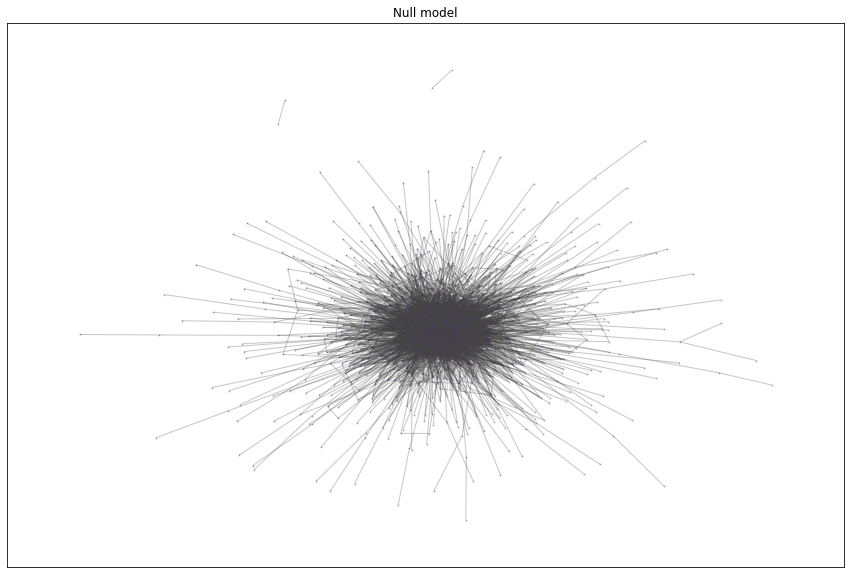

In [12]:
pos = nx.spring_layout(null_model, k = 0.1, weight = 'weight')

fig = plt.figure(figsize = (15, 10))
nx.draw_networkx(null_model, pos = pos, node_size = 1, node_color = '#552583', edge_color = '#444444', alpha = 0.3, with_labels = False)
plt.title('Null model')
plt.show()
plt.close()

In [13]:
def degree_distro(G, name) -> None:
    """Plot the degree distro of a network
    Parameters:
        G (nx.Graph): a network
        name (str): network name
    Returns:
        None"""
    
    degrees = np.array(list(dict(G.degree()).values()))
    k_min, k_max = min(degrees), max(degrees)

    bin_edges = np.logspace(np.log10(k_min), np.log10(k_max), num = 20)
    density, _ = np.histogram(degrees, bins = bin_edges, density = True)
    
    log_be = np.log10(bin_edges)
    x = 10 ** ((log_be[: -1] + log_be[1 :]) / 2)
    
    fig, ax = plt.subplots(figsize = (10, 8))
    plt.loglog(x, density, marker = 'o', ls = 'none', color = '#552583')
    plt.title('{} Degree Distribution'.format(name))
    plt.xlabel('Degree k')
    plt.ylabel('Density p(k)')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.show()
    plt.close()

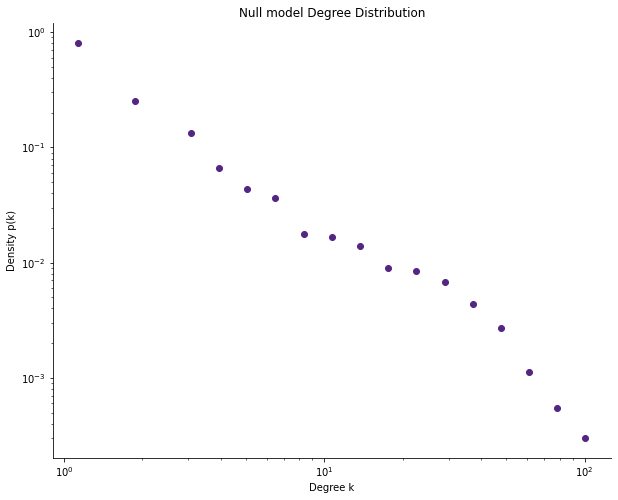

In [14]:
degree_distro(null_model, 'Null model')

In [15]:
def fit_powerlaw(G) -> float:
    """Fit a power law and calculate the degree exponent of a network
    Parameters:
        G (nx.Graph): the network
    Returns:
        float: the degree exponent gamma"""
    
    degrees = np.array(list(dict(G.degree()).values()))
    
    res = powerlaw.Fit(degrees, discrete = True)
    print('Gamma:', res.power_law.alpha)
    
    return res.power_law.alpha

In [16]:
fit_powerlaw(null_model)

Calculating best minimal value for power law fit
Gamma: 3.9153352464152666


3.9153352464152666

# Community Detection

In [17]:
REGION_MAP = {'Northeast': 1, 'South': 2, 'Midwest': 3, 'West': 4}

In [18]:
def add_node_community(G: nx.Graph, communities: list, label) -> None:
    """Add a marker for the community to the nodes
    Parameters:
        G (nx.Graph): a network
        communities (list): the list of communities
        label (str): the label for the community being added
    Returns:
        None"""
    
#     nx.set_node_attributes(G, values = 99, name = label)  # set default value for all nodes
    
    # set specific value for nodes we're interested in
    for i, com in enumerate(communities):
        for c in com:
            G.nodes[c][label] = i + 1

In [19]:
def add_edge_community(G: nx.Graph, label) -> None:
    """Add a marker for the community to the edges
    Parameters:
        G (nx.Graph): a network
        label (str): the label for the community
    Returns:
        None"""
    
    for x, y in G.edges:
#         if G.nodes[x][label] == G.nodes[y][label]:  # nodes are in the same community i.e. internal edge
        if label in G.nodes[x] and label in G.nodes[y] and G.nodes[x][label] == G.nodes[y][label]:  # nodes are in the same community i.e. internal edge
            G.edges[x, y][label] = G.nodes[x][label]
        else:  # external edge
            G.edges[x, y][label] = 0

In [20]:
def get_colour(i, r_off = 1, g_off = 1, b_off = 1) -> (float, float, float):
    """Get colour for a node
    Parameters:
        i (int): community label
        r_off (int): red offset
        g_off (int): green offset
        b_off (int): blue offset
    Returns:
        float: red value
        float: green value
        float: blue value"""
    
    n, low, high = 16, 0.1, 0.9
    span = high - low
    
    r = low + span * (((i + r_off) * 3) % n) / (n - 1)
    g = low + span * (((i + g_off) * 5) % n) / (n - 1)  
    b = low + span * (((i + b_off) * 7) % n) / (n - 1)
    
    return (r, g, b)

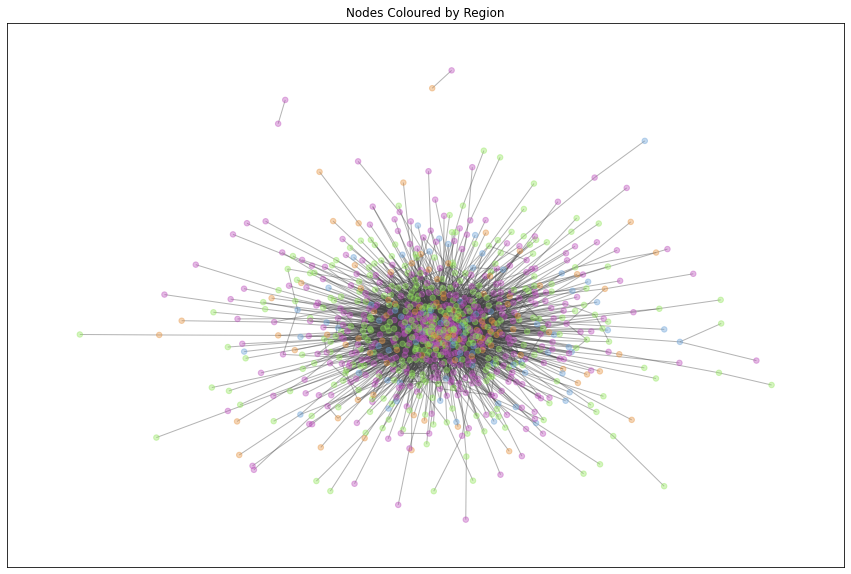

In [21]:
node_colour_region = [get_colour(REGION_MAP[null_model.nodes[i]['Region']]) for i in null_model.nodes]

fig = plt.figure(figsize = (15, 10))
nx.draw_networkx(null_model, pos = pos, node_size = 30, node_color = node_colour_region, edge_color = '#444444', alpha = 0.4, with_labels = False)
plt.title('Nodes Coloured by Region')
plt.show()
plt.close()

In [22]:
def community_plotter(G: nx.Graph, label, title) -> None:
    """Plot a network with communities
    Parameters:
        G (nx.Graph): a network
        label (str): the label for the community
        title (str): the title for the plot
    Returns:
        None"""
    
    external_edges = [(i, j) for i, j in G.edges if G.edges[i, j][label] == 0]
    internal_edges = [(i, j) for i, j in G.edges if G.edges[i, j][label] > 0]
    
#     com_nodes = [i for i in G.nodes if G.nodes[i][label] != 99]
    com_nodes = [i for i in G.nodes if label in G.nodes[i]]
    
    internal_colour = ['#000000' for _ in internal_edges]
    node_colour = [get_colour(G.nodes[i][label]) for i in com_nodes]
    
    fig = plt.figure(figsize = (15, 10))
    nx.draw_networkx(G, pos = pos, node_size = 30, nodelist = com_nodes, edgelist = external_edges, edge_color = '#000000', node_color = node_colour, style = 'dashed', alpha = 0.4, with_labels = False)
    nx.draw_networkx(G, pos = pos, node_size = 30, nodelist = com_nodes, edgelist = internal_edges, edge_color = internal_colour, node_color = node_colour, alpha = 0.4, with_labels = False)
    plt.title(title)
    plt.show()
    plt.close()

### 1. Greedy Modularity Maximization

In [23]:
def greedy_modularity_max(G: nx.Graph, weight = 'weight', threshold = 4, label = 'gmm') -> list:
    """Apply greedy modularity maximisation to find communities
    Parameters:
        G (nx.Graph): a network
        weight (str): the edge attribute
        threshold (int): minimum community size (default: 4)
        label (str): the label for the community (default: gmm)
    Returns:
        list: a list of communities detected"""
    
    gmm_com = nxc.greedy_modularity_communities(G, weight)
    
    filtered_gmm_com = [c for c in gmm_com if len(c) > threshold]
    
    print('Communities detected:', len(filtered_gmm_com))
    
    add_node_community(G, filtered_gmm_com, label)
    add_edge_community(G, label)
    
    community_plotter(G, label, 'Community Detection using Greedy Modularity Maximisation')
    
    return filtered_gmm_com

Communities detected: 11


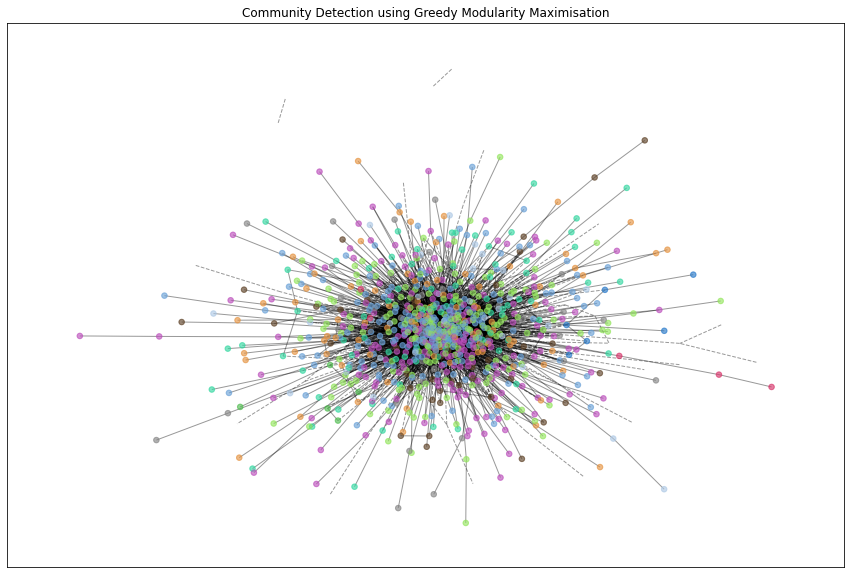

In [24]:
gmm_coms = greedy_modularity_max(null_model.copy())

### 2. k-cliques

In [25]:
def k_clique(G: nx.Graph, k, label = 'kclique') -> list:
    """Find k-clique communities
    Parameters:
        G (nx.Graph): a network
        k (int): clique size
        label (str): the label for the community (default: kclique)
    Returns:
        list: a list of communities detected"""
    
    kc_com = list(nxc.k_clique_communities(G, 5))
    
    print('Communities detected:', len(kc_com))
    
    add_node_community(G, kc_com, label)
    add_edge_community(G, label)
    
    community_plotter(G, label, 'Community Detection using {}-Cliques'.format(k))
    
    return kc_com

Communities detected: 10


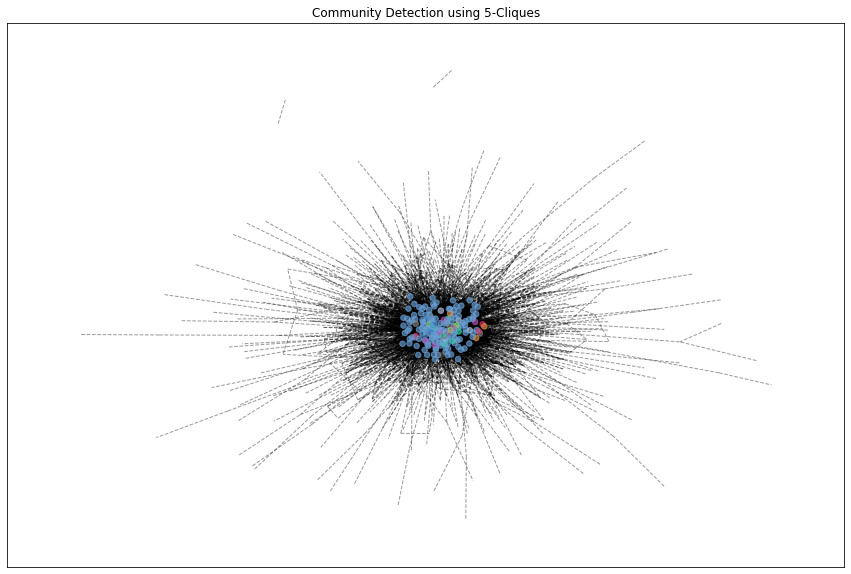

In [26]:
kc_coms = k_clique(null_model.copy(), 5)